__Imports__

In [19]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

__SOM implementation__

In [33]:
class SOMClustering:
    def __init__(self, X, num_clusters, sigma=1., learning_rate=0.5):
        self.K = num_clusters
        self.num_examples, self.num_features = X.shape
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.weights = np.random.rand(self.K, self.num_features)

    def fit(self, X, num_epochs=100):
        for epoch in range(num_epochs):
            for i, x in enumerate(X):
                distances = np.linalg.norm(x - self.weights, axis=1)
                winner = np.argmin(distances)
                for j in range(self.K):
                    if np.abs(j - winner) <= self.sigma:
                        self.weights[j] += self.learning_rate * (x - self.weights[j])
            self.sigma = self.sigma * 0.9
            self.learning_rate = self.learning_rate * 0.9

        self.cluster_labels = np.zeros(self.num_examples)
        for i, x in enumerate(X):
            distances = np.linalg.norm(x - self.weights, axis=1)
            self.cluster_labels[i] = np.argmin(distances)

        self.centroids = np.zeros((self.K, self.num_features))
        for i in range(self.K):
            cluster_points = X[self.cluster_labels == i]
            if len(cluster_points) > 0:
                self.centroids[i] = np.mean(cluster_points, axis=0)
            else:
                self.centroids[i] = np.random.random(self.num_features)

    def get_centroids(self):
        return self.centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def calculate_inertia(self, X):
        inertia = 0
        for i, x in enumerate(X):
            distances = np.linalg.norm(x - self.centroids, axis=1)
            cluster_label = int(self.cluster_labels[i])
            inertia += distances[cluster_label] ** 2
        return inertia

__Reading and processing dataset__

In [34]:
np.random.seed(10)
num_clusters = 3
df = pd.read_csv('Wholesale customers data.csv')
scaler=preprocessing.StandardScaler()
data_scaled=scaler.fit_transform(df)

__Training and storing silhoutte, calinski harabasz and inertia scores__

In [35]:
cluster_range = range(2, 10)  # start from 2 because silhouette_score and calinski_harabasz_score expect at least 2 clusters
sse_values = []
silhouette_scores = []
ch_scores = []

for clusters in cluster_range:
    som = SOMClustering(data_scaled, clusters)
    som.fit(data_scaled)
    y_pred = som.predict(data_scaled)
    sse_values.append(som.calculate_inertia(data_scaled))
    silhouette_scores.append(silhouette_score(data_scaled, y_pred))
    ch_scores.append(calinski_harabasz_score(data_scaled, y_pred))

__Plots for the number of clusters vs scores__

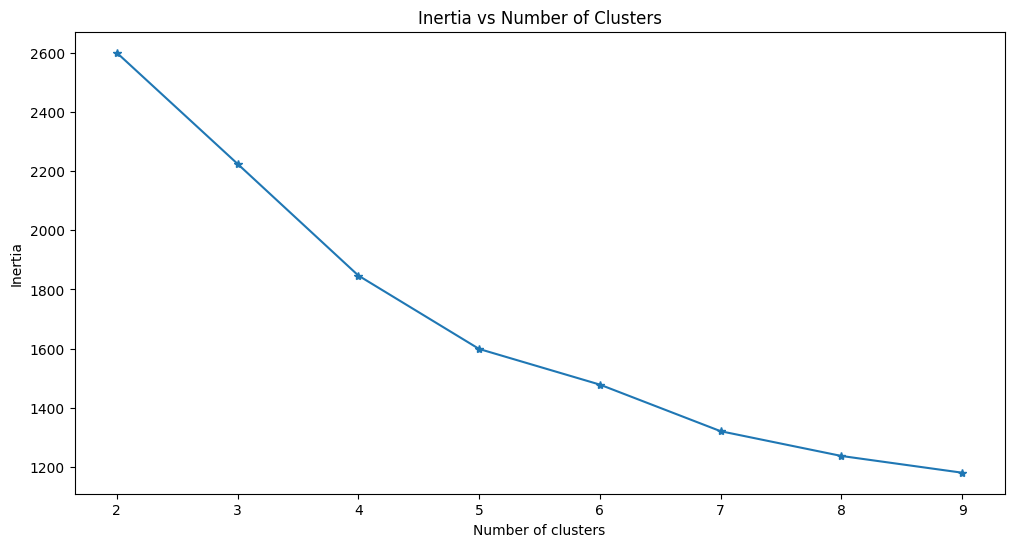

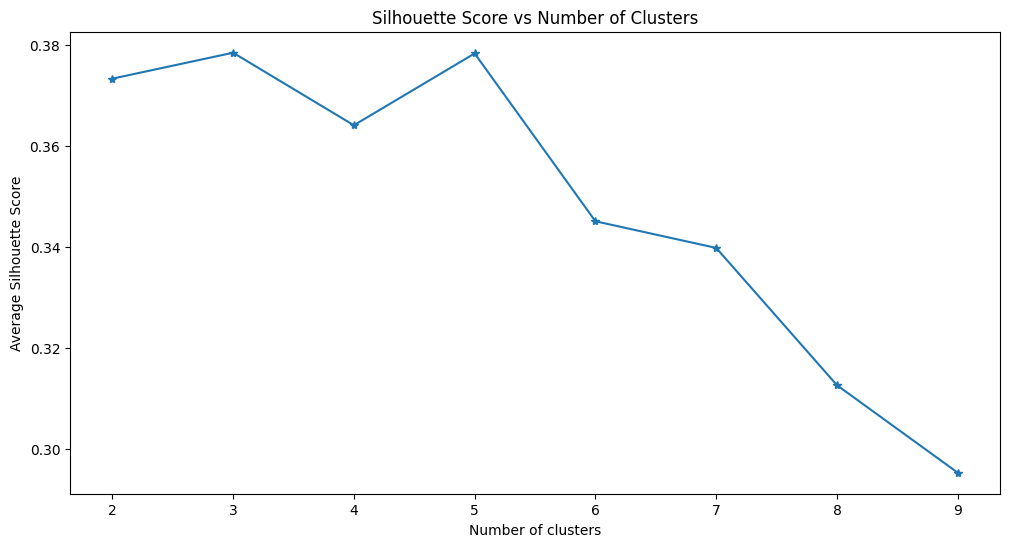

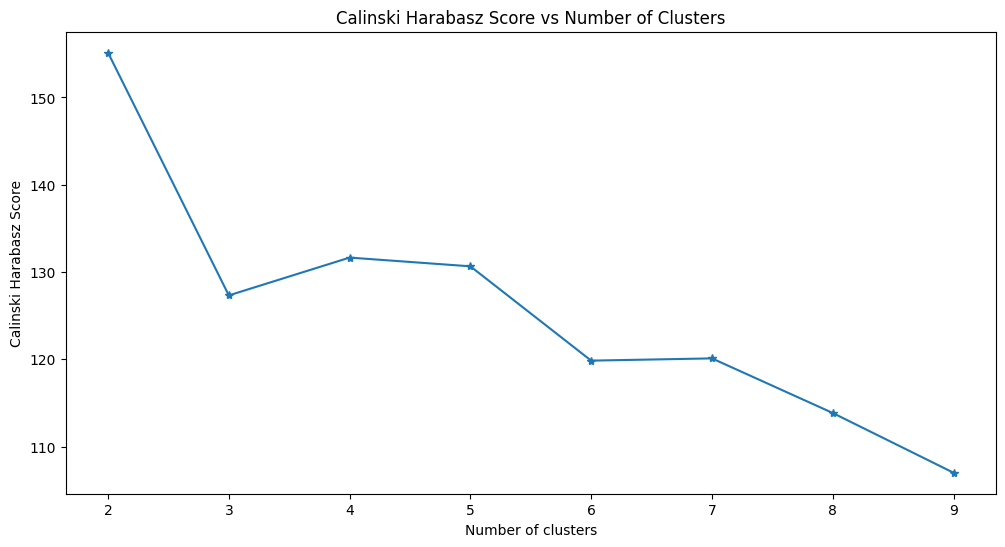

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, sse_values, marker="*")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(cluster_range, silhouette_scores, marker="*")
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(cluster_range, ch_scores, marker="*")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('Calinski Harabasz Score vs Number of Clusters')
plt.show()
    

__Grouping the data__

In [38]:
som = SOMClustering(data_scaled, 7)
som.fit(data_scaled)
print("Inertia: ", som.calculate_inertia(data_scaled))


som = SOMClustering(data_scaled, 7)
som.fit(data_scaled)
groups = som.predict(data_scaled)

frame = pd.DataFrame(data_scaled)
frame['cluster'] = groups
print(frame['cluster'].value_counts())

dataset = df.copy()
dataset["cluster"] = groups

fig = px.scatter_3d(dataset, x="Grocery", y="Milk", z="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()


print(dataset.head(10))

# Describe the data by cluster
# First table
first_table = dataset.groupby('cluster').agg({
    'Channel': 'mean',
    'Region': 'mean',
    'Fresh': 'median',
    'Milk': 'median',
    'Grocery': 'median',
    'Frozen': 'median',
    'Detergents_Paper': 'median',
    'Delicassen': 'median'}).round(2)

print(first_table)


first_table.to_csv('first_tablemedian.csv')

print("standard deviation of each cluster")

# Second table
second_table = dataset.groupby('cluster').agg({
        'Channel':  'std',
        'Region':  'std',
        'Fresh':  'std',
        'Milk':  'std',
        'Grocery':  'std',
        'Frozen':  'std',
        'Detergents_Paper':  'std',
        'Delicassen':  'std'}).round(2)

second_table.to_csv('first_tablestandard_deviation.csv')

print(second_table)

Inertia:  1321.2063607424197
3    251
2    105
0     46
6     31
5      4
4      2
1      1
Name: cluster, dtype: int64


   Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669   9656     7561     214              2674   
1        2       3   7057   9810     9568    1762              3293   
2        2       3   6353   8808     7684    2405              3516   
3        1       3  13265   1196     4221    6404               507   
4        2       3  22615   5410     7198    3915              1777   
5        2       3   9413   8259     5126     666              1795   
6        2       3  12126   3199     6975     480              3140   
7        2       3   7579   4956     9426    1669              3321   
8        1       3   5963   3648     6192     425              1716   
9        2       3   6006  11093    18881    1159              7425   

   Delicassen  cluster  
0        1338        2  
1        1776        2  
2        7844        2  
3        1788        3  
4        5185        2  
5        1451        2  
6         545        2  
7        2566     

Clustering with Fresh and Grocery


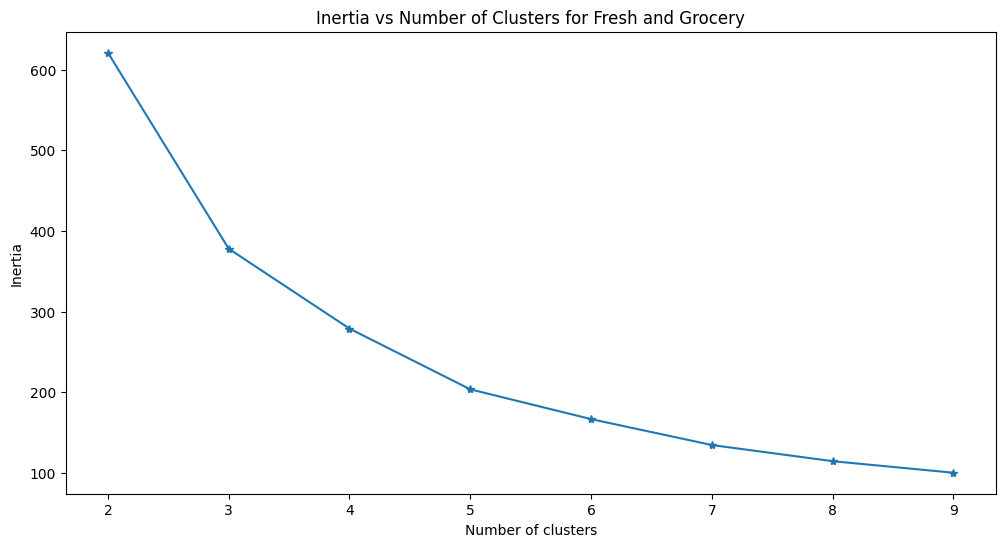

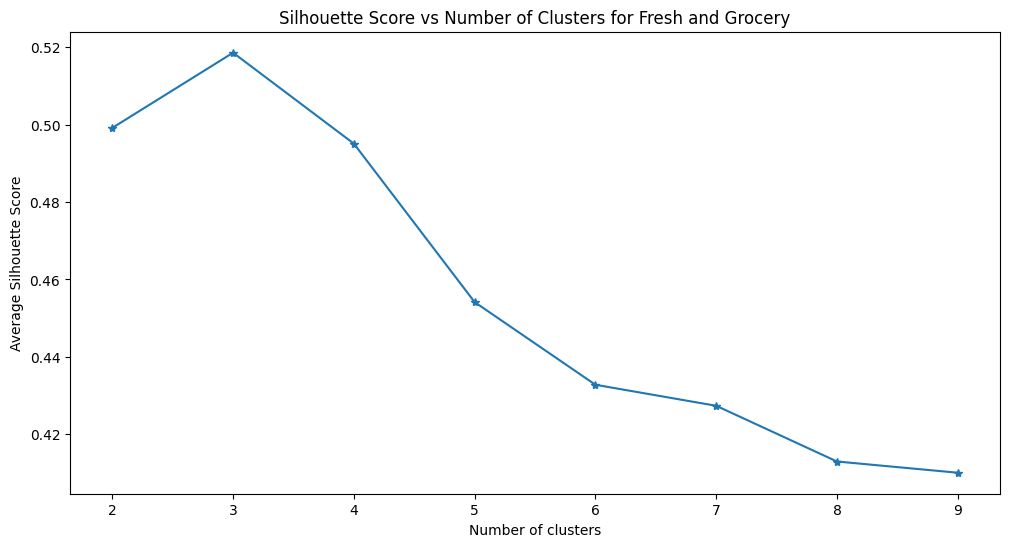

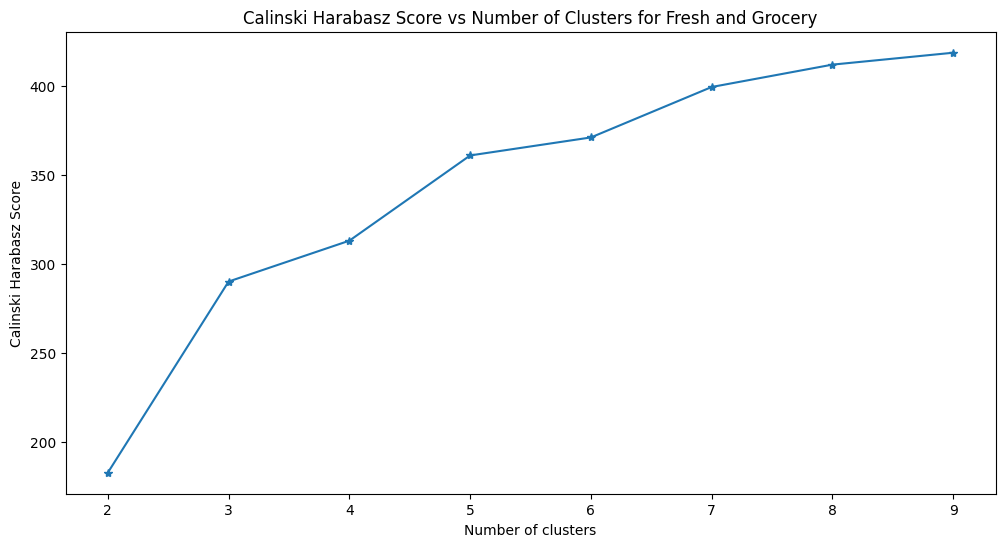

Clustering with Fresh and Frozen


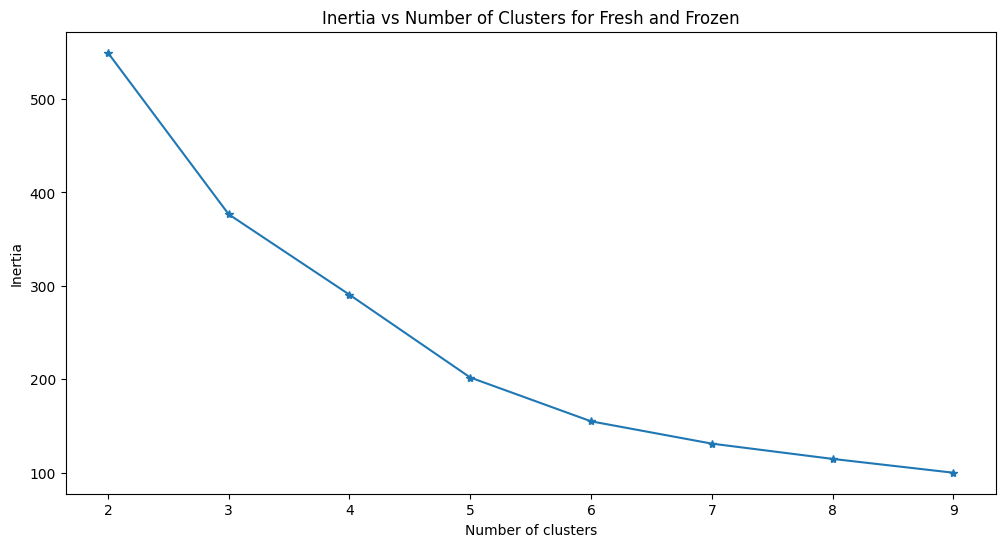

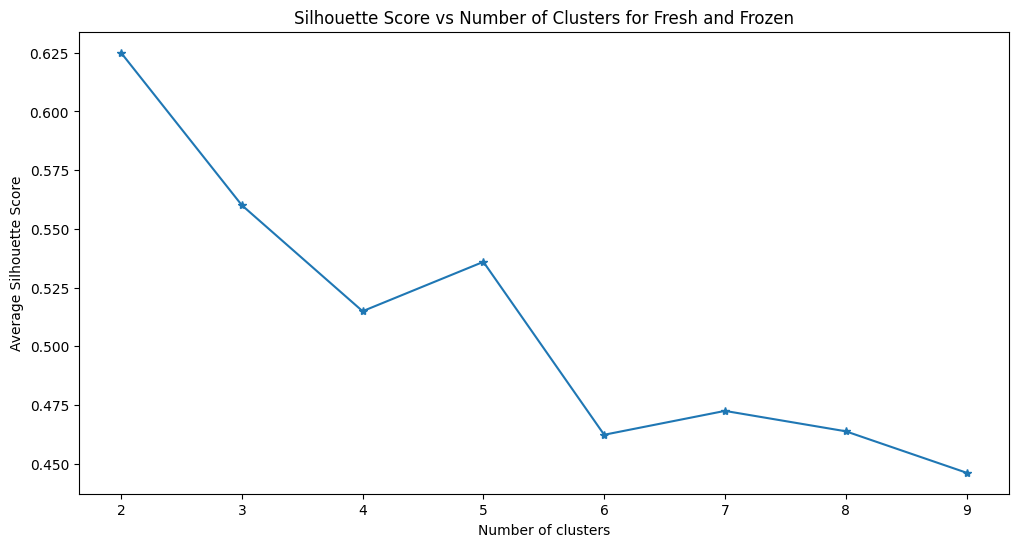

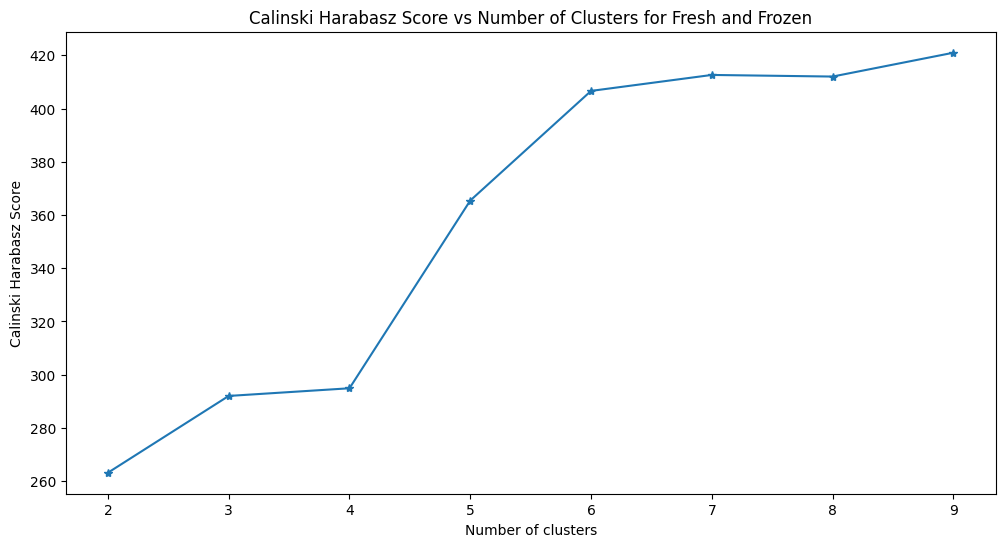

Clustering with Milk and Fresh


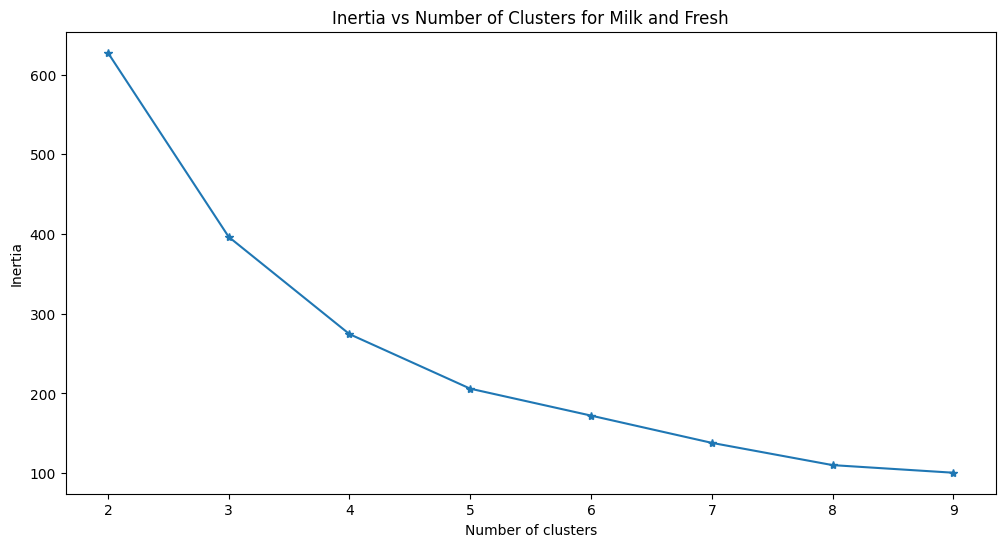

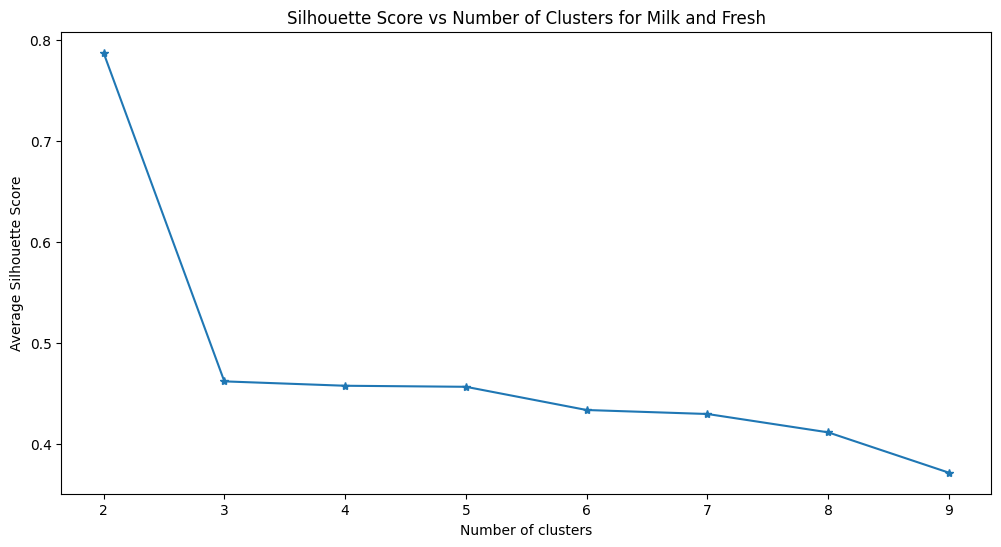

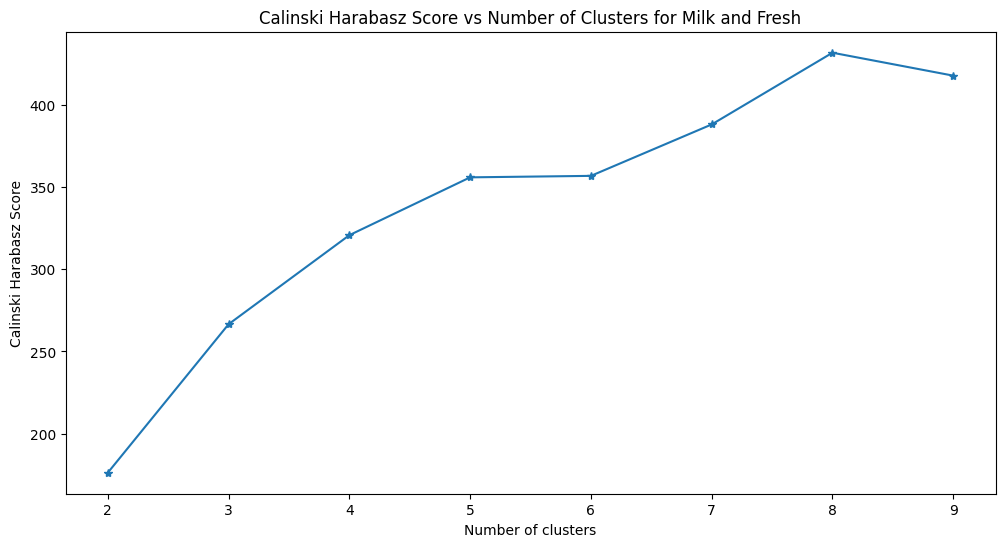

In [39]:
cluster_range = range(2, 10) 
sse_values = []
silhouette_scores = []
ch_scores = []

for clusters in cluster_range:
        som = SOMClustering(data_scaled, clusters)
        som.fit(data_scaled)
        y_pred = som.predict(data_scaled)
        sse_values.append(som.calculate_inertia(data_scaled))
        silhouette_scores.append(silhouette_score(data_scaled, y_pred))
        ch_scores.append(calinski_harabasz_score(data_scaled, y_pred))


def cluster_and_visualize(df, attr1, attr2, cluster_range):
    data = df[[attr1, attr2]]
    data_scaled = preprocessing.StandardScaler().fit_transform(data)

    sse_values = []
    silhouette_scores = []
    ch_scores = []

    for clusters in cluster_range:
        som = SOMClustering(data_scaled, clusters)
        som.fit(data_scaled)
        y_pred = som.predict(data_scaled)
        sse_values.append(som.calculate_inertia(data_scaled))
        silhouette_scores.append(silhouette_score(data_scaled, y_pred))
        ch_scores.append(calinski_harabasz_score(data_scaled, y_pred))

    # plot the results
    # here I'm adding plots for each attribute pair
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, sse_values, marker="*")
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'Inertia vs Number of Clusters for {attr1} and {attr2}')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, silhouette_scores, marker="*")
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title(f'Silhouette Score vs Number of Clusters for {attr1} and {attr2}')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(cluster_range, ch_scores, marker="*")
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski Harabasz Score')
    plt.title(f'Calinski Harabasz Score vs Number of Clusters for {attr1} and {attr2}')
    plt.show()

    return sse_values, silhouette_scores, ch_scores

cluster_range = range(2, 10)

# Perform clustering with different attributes
pairs = [ 
         ('Fresh', 'Grocery'), 
         ('Fresh', 'Frozen'), 
         ('Milk', 'Fresh')]

# Perform clustering with specific pairs of attributes
results = {}
for pair in pairs:
    print(f"Clustering with {pair[0]} and {pair[1]}")
    sse_values, silhouette_scores, ch_scores = cluster_and_visualize(df, pair[0], pair[1], cluster_range)
    results[pair] = {"sse_values": sse_values, "silhouette_scores": silhouette_scores, "ch_scores": ch_scores}

Clustering with Fresh and Grocery with 5 clusters


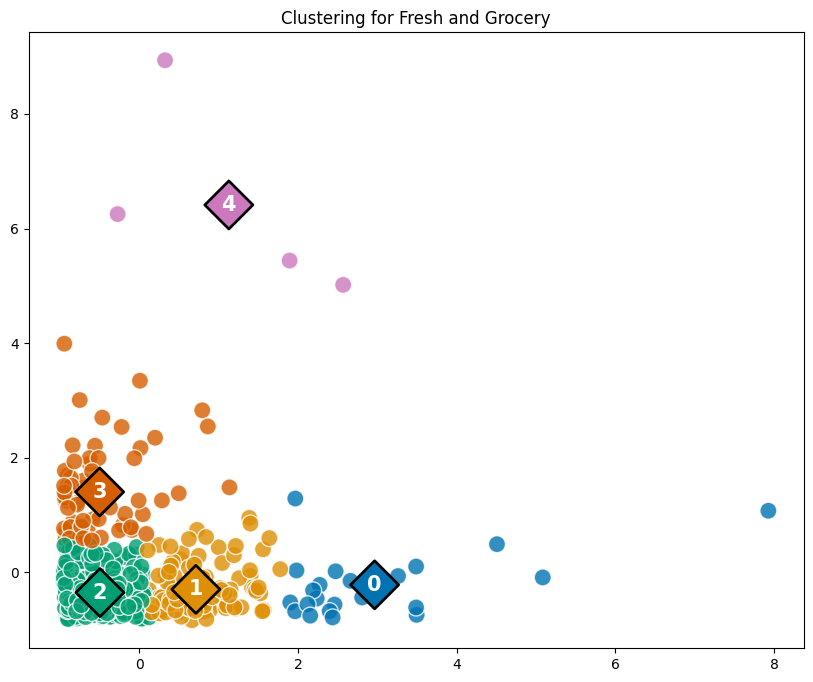

Clustering with Fresh and Frozen with 7 clusters


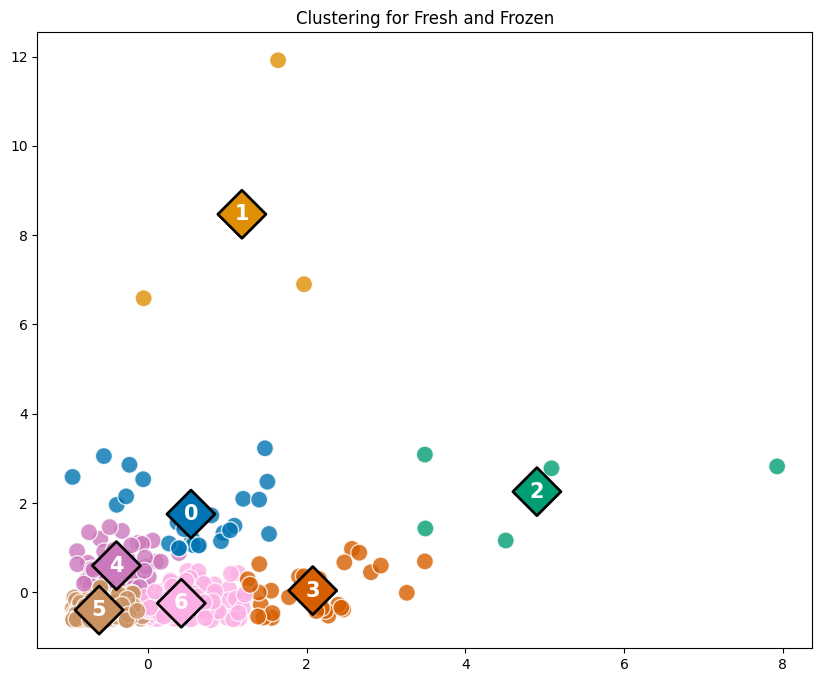

Clustering with Milk and Fresh with 5 clusters


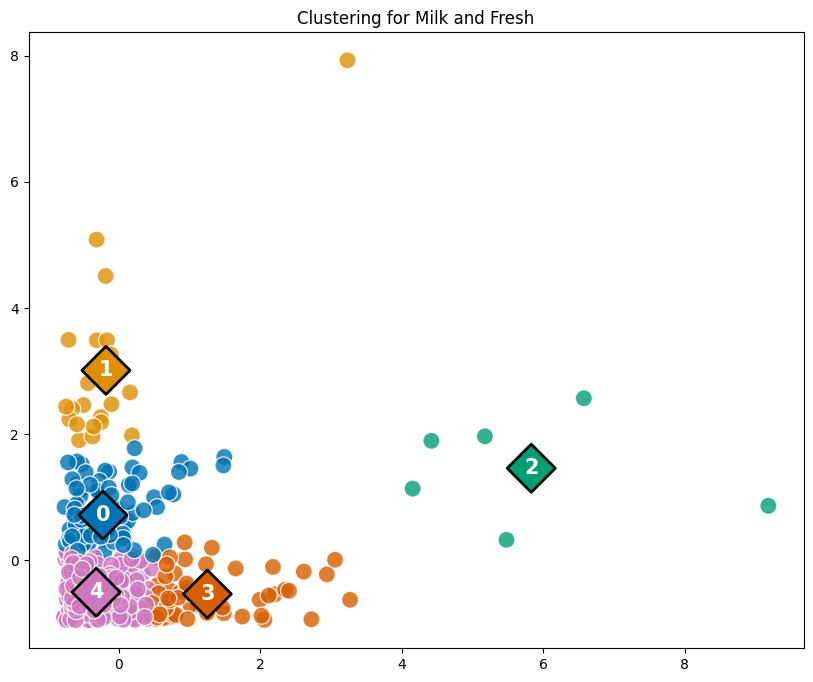

For Fresh and Grocery with 5 clusters:
 - Cluster 0 has 23 points.
 - Cluster 1 has 109 points.
 - Cluster 2 has 236 points.
 - Cluster 3 has 68 points.
 - Cluster 4 has 4 points.
For Fresh and Frozen with 7 clusters:
 - Cluster 0 has 26 points.
 - Cluster 1 has 3 points.
 - Cluster 2 has 5 points.
 - Cluster 3 has 30 points.
 - Cluster 4 has 50 points.
 - Cluster 5 has 214 points.
 - Cluster 6 has 112 points.
For Milk and Fresh with 5 clusters:
 - Cluster 0 has 110 points.
 - Cluster 1 has 22 points.
 - Cluster 2 has 6 points.
 - Cluster 3 has 58 points.
 - Cluster 4 has 244 points.


In [40]:
cluster_range = range(2, 10)  # start from 2 because silhouette_score and calinski_harabasz_score expect at least 2 clusters
sse_values = []
silhouette_scores = []
ch_scores = []

for clusters in cluster_range:
        som = SOMClustering(data_scaled, clusters)
        som.fit(data_scaled)
        y_pred = som.predict(data_scaled)
        sse_values.append(som.calculate_inertia(data_scaled))
        silhouette_scores.append(silhouette_score(data_scaled, y_pred))
        ch_scores.append(calinski_harabasz_score(data_scaled, y_pred))


def cluster_and_visualize(df, attr1, attr2, num_clusters):
    data = df[[attr1, attr2]]
    scaler = preprocessing.StandardScaler()
    data_scaled = scaler.fit_transform(data)

    som = SOMClustering(data_scaled, num_clusters)
    som.fit(data_scaled)
    y_pred = som.predict(data_scaled)
    centroids = som.get_centroids()

    # create a scatter plot for the best number of clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=data_scaled[:, 0], y=data_scaled[:, 1], hue=y_pred, palette='colorblind', alpha=0.8, s=150, legend=False)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], hue=range(num_clusters), palette='colorblind', s=600, marker='D', ec='black', legend=False)
    for i in range(num_clusters):
        plt.text(x=centroids[i, 0], y=centroids[i, 1], s=i, horizontalalignment='center', verticalalignment='center', size=15, weight='bold', color='white')
    plt.title(f'Clustering for {attr1} and {attr2}')
    plt.show()

    return y_pred, centroids



cluster_range = range(2, 10)

# Perform clustering with different attributes
pairs = [
        ('Fresh', 'Grocery'), 
        ('Fresh', 'Frozen'), 

        ('Milk', 'Fresh')]

# Perform clustering with specific pairs of attributes
results = {}
pairs = [ 
        ('Fresh', 'Grocery', 5), 
        ('Fresh', 'Frozen', 7), 
        
        ('Milk', 'Fresh', 5)]

# Perform clustering with specific pairs of attributes
for pair in pairs:
    print(f"Clustering with {pair[0]} and {pair[1]} with {pair[2]} clusters")
    y_pred, centroids = cluster_and_visualize(df, pair[0], pair[1], pair[2])
    results[pair] = (y_pred, centroids)

for pair, (y_pred, centroids) in results.items():
    unique, counts = np.unique(y_pred, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    print(f"For {pair[0]} and {pair[1]} with {pair[2]} clusters:")
    for cluster, count in cluster_counts.items():
        print(f" - Cluster {cluster} has {count} points.")

In [41]:
som = SOMClustering(data_scaled, 7)
som.fit(data_scaled)
y_pred = som.predict(data_scaled)
print("Inertia: ", som.calculate_inertia(data_scaled))

som = SOMClustering(data_scaled, 7)
som.fit(data_scaled)
y_pred = som.predict(data_scaled)

frame = pd.DataFrame(data_scaled)
frame['cluster'] = groups
print(frame['cluster'].value_counts())

dataset = df.copy()
dataset["cluster"] = groups

fig = px.scatter_3d(dataset, x="Grocery", y="Milk", z="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter_3d(dataset, x="Frozen", y="Milk", z="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter_3d(dataset, x="Detergents_Paper", y="Milk", z="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter_3d(dataset, x="Delicassen", y="Milk", z="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter_3d(dataset, x="Channel", y="Milk", z="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter_3d(dataset, x="Region", y="Milk", z="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter(dataset, x="Grocery", y="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter(dataset, x="Frozen", y="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter(dataset, x="Detergents_Paper", y="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

fig = px.scatter(dataset, x="Delicassen", y="Fresh", color='cluster', size="Fresh", size_max=30)
fig.show()

Inertia:  1321.2063607424197
3    251
2    105
0     46
6     31
5      4
4      2
1      1
Name: cluster, dtype: int64
